## Import Packages and NLTK Downloads

In [ ]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

#import contractions

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 10.1 MB/s eta 0:00:00


In [ ]:
import contractions

In [ ]:
# https://github.com/explosion/spaCy/issues/11909
import locale
locale.getpreferredencoding()

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!python -m spacy download en_core_web_lg

2023-06-01 14:51:19.573154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 14:51:21.101061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-01 14:51:22.917559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 14:51:22.918218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

# Mount Google Drive to Colab Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls -l /content/drive

total 4
drwx------ 7 root root 4096 Jun  1 14:57 MyDrive


In [ ]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [ ]:
import pkg_resources
#pkg_resources.require("gensim<=3.8.3");
print("Genism Version: ", gensim.__version__)

# suppress warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Genism Version:  4.3.1


In [ ]:
@dataclass
class Document:
    doc_id: str
    text: str


def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()

def remove_tags(text):
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|[^\w])+"," ", text)

def normalize(input_text):
    '''
    Normalization involves the following steps:
    1. Remove punctuation
    2. Lower case all words
    3. Remove tags (i.e., HTML tags)
    4. Remove all special characters and digits
    '''
    text = remove_special_chars_and_digits(input_text)
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)

    return text

STOP_WORDS = set(nltk.corpus.stopwords.words('english'))
def remove_stop_words(tokenized_text):
    return [w for w in tokenized_text if not w in STOP_WORDS]

# https://towardsdatascience.com/benchmarking-python-nlp-tokenizers-3ac4735100c5

WORD = re.compile(r'\w+')
def reg_tokenize(text):
    words = WORD.findall(text)
    tokenized_words = remove_stop_words(words)

    return tokenized_words

def lemmatize(tokenized_text, lemmatizer=WordNetLemmatizer()):
    '''
    Lemmatization is applied to each word in the list of normalized tokens
    (stop words are removed)
    '''
    return [lemmatizer.lemmatize(word) for word in tokenized_text]

def join_tokens(lemmatized_tokens):
    return ' '.join(lemmatized_tokens)

def remove_custom_stop_words(tokenized_text):
    stop_words = ['film', 'movie', 'character', 'story', 'year', 'also', 'though']
    return [w for w in tokenized_text if not w in stop_words]

def remove_short_tokens(tokenized_text):
    other_words = ['makes', 'people', 'things', 'think']
    tokens = [word for word in tokenized_text if (len(word) > 4) & (not word in other_words)]

    return tokens



def remove_special_chars_and_digits_2(text):        # doesn't remove '
    return re.sub("(\\d|[^\w'])+"," ", text)

def normalize_2(input_text):
    '''
    Normalization involves the following steps:
    1. Remove punctuation
    2. Lower case all words
    3. Remove tags (i.e., HTML tags)
    4. Remove all special characters and digits
    '''
    text = remove_special_chars_and_digits(input_text)   # doesn't remove '
    text = contractions.fix(text)                        # converts I'd to I would
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)

    return text

def remove_custom_stop_words_2(tokenized_text):
    stop_words = []
#    ['film', 'movie', 'character', 'story', 'year', 'also', 'though', 'would', 'movies', 'films',
#                 'characters', 'https']
    return [w for w in tokenized_text if not w in stop_words]

def remove_short_tokens(tokenized_text):
    other_words = ['first', 'world', 'could']
    tokens = [word for word in tokenized_text if (len(word) > 2) & (not word in other_words)]

    return tokens

In [ ]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [ ]:
corpus_df = pd.read_csv("golf_transcripts.csv", encoding="utf-8")
print(corpus_df)

        video_id                                              title   views  \
0    tzKZjIl5f9Y  Mike Malaska: Joe Nicols and the Theory of the...  300321   
1    egAV1SzWRVI  Mike Malaska On Distance -- The Best "Formula"...  287488   
2    3O72CKDfrQ4  Mike Malaska And Bob Toski -- Golf's Most Crit...   63358   
3    T8YZim8kTiE  Tiger Woods - Swing Evolution Around Injuries ...   72658   
4    N4Jv5UTJmPE    Mike Malaska and Julie Yang -- downswing theory  148907   
..           ...                                                ...     ...   
199  pJEHBAojpKk  How Do I Hit The Ball Higher Without Hitting I...   19741   
200  CBoKdnL3RFw  How To Practice Correctly - Taking Time Betwee...   15401   
201  XPLkRvOEmGQ  This ONE Hip Move Could Fix Your Entire Swing ...   73220   
202  yjnsf2YUz3U           Ask Mike //  Practice What Works For You   17195   
203  VRsEUOO-NyM  The Right Grip For Speed Producers / Hold The ...   20097   

      likes  release_year                          

In [ ]:
len(corpus_df)

204

In [ ]:
corpus_df['transcript_ID'] = [x+1 for x in range(len(corpus_df))]

In [ ]:
corpus_df.head()

,video_id,title,views,likes,release_year,description,transcript,views to likes ratio,transcript_ID
0,tzKZjIl5f9Y,Mike Malaska: Joe Nicols and the Theory of the...,300321,NaN,2015,MalaskaGolf.com -- Mike's new teaching site --...,when it comes to golf careers I mean I've been...,NaN,1
1,egAV1SzWRVI,"Mike Malaska On Distance -- The Best ""Formula""...",287488,NaN,2010,"Mike's first book, I Feel Your Pain is availab...",[Music] hi welcome to golfers MD I'm Mike Mill...,NaN,2
2,3O72CKDfrQ4,Mike Malaska And Bob Toski -- Golf's Most Crit...,63358,159.0,2014,MalaskaGolf.com - teaching site goes live Dece...,now what do you want me to do it straight alri...,398.477987,3
3,T8YZim8kTiE,Tiger Woods - Swing Evolution Around Injuries ...,72658,272.0,2021,Mike gives his perspective on Tiger Woods' swi...,[Music] [Applause] alaska news so tiger's the ...,267.125000,4
4,N4Jv5UTJmPE,Mike Malaska and Julie Yang -- downswing theory,148907,628.0,2015,"Mike's First Book ""I Feel Your Pain"" is availa...",first tournament so how'd it feel good good so...,237.113057,5


### Get rid of the 'Music' or 'Music Applause' at the beginning of some transcripts

In [ ]:
corpus_df['transcript'] = corpus_df['transcript'].str.replace('\[Music\]', '', regex=True)
corpus_df['transcript'] = corpus_df['transcript'].str.replace('\[Applause\]', '', regex=True)

In [ ]:
corpus_df.head()

,video_id,title,views,likes,release_year,description,transcript,views to likes ratio,transcript_ID
0,tzKZjIl5f9Y,Mike Malaska: Joe Nicols and the Theory of the...,300321,NaN,2015,MalaskaGolf.com -- Mike's new teaching site --...,when it comes to golf careers I mean I've been...,NaN,1
1,egAV1SzWRVI,"Mike Malaska On Distance -- The Best ""Formula""...",287488,NaN,2010,"Mike's first book, I Feel Your Pain is availab...",hi welcome to golfers MD I'm Mike Mille ask a...,NaN,2
2,3O72CKDfrQ4,Mike Malaska And Bob Toski -- Golf's Most Crit...,63358,159.0,2014,MalaskaGolf.com - teaching site goes live Dece...,now what do you want me to do it straight alri...,398.477987,3
3,T8YZim8kTiE,Tiger Woods - Swing Evolution Around Injuries ...,72658,272.0,2021,Mike gives his perspective on Tiger Woods' swi...,alaska news so tiger's the big news here we ...,267.125000,4
4,N4Jv5UTJmPE,Mike Malaska and Julie Yang -- downswing theory,148907,628.0,2015,"Mike's First Book ""I Feel Your Pain"" is availa...",first tournament so how'd it feel good good so...,237.113057,5


In [ ]:
corpus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   video_id              204 non-null    object 
 1   title                 204 non-null    object 
 2   views                 204 non-null    int64  
 3   likes                 202 non-null    float64
 4   release_year          204 non-null    int64  
 5   description           202 non-null    object 
 6   transcript            204 non-null    object 
 7   views to likes ratio  202 non-null    float64
 8   transcript_ID         204 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 14.5+ KB


In [ ]:
corpus_df['normalized_review'] = corpus_df['transcript'].apply(normalize_2)
corpus_df['tokenized_review'] = corpus_df['normalized_review'].apply(reg_tokenize)
corpus_df['lemmatized_tokens'] = corpus_df['tokenized_review'].apply(lemmatize)
corpus_df['full_lemmatized_text'] = corpus_df['lemmatized_tokens'].apply(remove_custom_stop_words_2)
corpus_df['lemmatized_text'] = corpus_df['full_lemmatized_text'].apply(join_tokens)

In [ ]:
corpus_df.head()

,video_id,title,views,likes,release_year,description,transcript,views to likes ratio,transcript_ID,normalized_review,tokenized_review,lemmatized_tokens,full_lemmatized_text,lemmatized_text
0,tzKZjIl5f9Y,Mike Malaska: Joe Nicols and the Theory of the...,300321,NaN,2015,MalaskaGolf.com -- Mike's new teaching site --...,when it comes to golf careers I mean I've been...,NaN,1,when it comes to golf careers i mean i ve been...,"[comes, golf, careers, mean, lucky, around, lo...","[come, golf, career, mean, lucky, around, lot,...","[come, golf, career, mean, lucky, around, lot,...",come golf career mean lucky around lot really ...
1,egAV1SzWRVI,"Mike Malaska On Distance -- The Best ""Formula""...",287488,NaN,2010,"Mike's first book, I Feel Your Pain is availab...",hi welcome to golfers MD I'm Mike Mille ask a...,NaN,2,hi welcome to golfers md i m mike mille ask a...,"[hi, welcome, golfers, md, mike, mille, ask, d...","[hi, welcome, golfer, md, mike, mille, ask, di...","[hi, welcome, golfer, md, mike, mille, ask, di...",hi welcome golfer md mike mille ask director i...
2,3O72CKDfrQ4,Mike Malaska And Bob Toski -- Golf's Most Crit...,63358,159.0,2014,MalaskaGolf.com - teaching site goes live Dece...,now what do you want me to do it straight alri...,398.477987,3,now what do you want me to do it straight alri...,"[want, straight, alright, okay, fufufufu, hit,...","[want, straight, alright, okay, fufufufu, hit,...","[want, straight, alright, okay, fufufufu, hit,...",want straight alright okay fufufufu hit ball p...
3,T8YZim8kTiE,Tiger Woods - Swing Evolution Around Injuries ...,72658,272.0,2021,Mike gives his perspective on Tiger Woods' swi...,alaska news so tiger's the big news here we ...,267.125000,4,alaska news so tiger s the big news here we a...,"[alaska, news, tiger, big, news, red, black, u...","[alaska, news, tiger, big, news, red, black, u...","[alaska, news, tiger, big, news, red, black, u...",alaska news tiger big news red black uh uh abs...
4,N4Jv5UTJmPE,Mike Malaska and Julie Yang -- downswing theory,148907,628.0,2015,"Mike's First Book ""I Feel Your Pain"" is availa...",first tournament so how'd it feel good good so...,237.113057,5,first tournament so how d it feel good good so...,"[first, tournament, feel, good, good, think, l...","[first, tournament, feel, good, good, think, l...","[first, tournament, feel, good, good, think, l...",first tournament feel good good think like tim...


In [ ]:
# https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stoplist = stopwords.words('english') + ['though']
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,2))
# matrix of ngrams
ngrams = c_vec.fit_transform(corpus_df['lemmatized_text'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram'})

In [ ]:
additional_grams = df_ngram[df_ngram['frequency'] > 6]['bigram'].tolist()

In [ ]:
additional_grams[:10]

['feel like',
 'club head',
 'hit ball',
 'little bit',
 'momentum club',
 'go back',
 'right arm',
 'golf swing',
 'go way',
 'right hand']

In [ ]:
# Formula to take the bigrams

def add_bigrams_to_review(tokens, important_bigrams):
    new_tokens = []
    skip_next_token = False
    bigrams_set = set(important_bigrams)

    for i, token in enumerate(tokens[:-1]):
        if skip_next_token:
            skip_next_token = False
            continue

        bigram_str = f"{token} {tokens[i + 1]}"

        if bigram_str in bigrams_set:
            new_tokens.append(bigram_str.replace(' ', '_'))
            skip_next_token = True
        else:
            new_tokens.append(token)

    if not skip_next_token:
        new_tokens.append(tokens[-1])

    return new_tokens

# Add important bigrams to the tokenized reviews
reviews_with_bigrams = [add_bigrams_to_review(review, additional_grams) for review in corpus_df['tokenized_review']]

# Create a new DataFrame column with the reviews including important bigrams
print([' '.join(review) for review in reviews_with_bigrams])

['comes golf careers mean lucky around lot_really good people lot_different industries golf industry one person really_really impact understood golf_swing probably better anybody ever around relative get_people create_speed talk release talked momentum talked lot things people_even understand golf_swing even concepts look_right made club_work correctly_going talk little_bit show philosophy good far ahead time name joe_nichols joe played lot_golf back stuff like great player understood watching different players learned_lot things make_club work philosophy basically three balance points golf_swing three corners flat spot mean plus believed primary secondary line sounds really complicated show understand going understand play_game swing_golf club_would call primary line_target line wanted ball_go line_back secondary line parallel_target line_right directly drop line straight ground underneath handle_club right underneath handle_club primary line_ball secondary line handle believed club w

In [ ]:
corpus_df['bigram'] = [' '.join(review) for review in reviews_with_bigrams]
corpus_df['bigram_tokenized'] = corpus_df['bigram'].apply(reg_tokenize)
corpus_df['bigram_tokenized_2'] = corpus_df['bigram_tokenized'].apply(remove_short_tokens)
corpus_df['bigram_tokenized_final'] = corpus_df['bigram_tokenized_2'].apply(remove_custom_stop_words_2)
corpus_df['bigram_final'] = corpus_df['bigram_tokenized_final'].apply(join_tokens)
print(corpus_df.head())

      video_id                                              title   views  \
0  tzKZjIl5f9Y  Mike Malaska: Joe Nicols and the Theory of the...  300321   
1  egAV1SzWRVI  Mike Malaska On Distance -- The Best "Formula"...  287488   
2  3O72CKDfrQ4  Mike Malaska And Bob Toski -- Golf's Most Crit...   63358   
3  T8YZim8kTiE  Tiger Woods - Swing Evolution Around Injuries ...   72658   
4  N4Jv5UTJmPE    Mike Malaska and Julie Yang -- downswing theory  148907   

   likes  release_year                                        description  \
0    NaN          2015  MalaskaGolf.com -- Mike's new teaching site --...   
1    NaN          2010  Mike's first book, I Feel Your Pain is availab...   
2  159.0          2014  MalaskaGolf.com - teaching site goes live Dece...   
3  272.0          2021  Mike gives his perspective on Tiger Woods' swi...   
4  628.0          2015  Mike's First Book "I Feel Your Pain" is availa...   

                                          transcript  views to likes ratio

## Count Vectorizer

In [ ]:
# counts number of times words appears in a document
c_vectorizer = CountVectorizer(ngram_range=(1,2))              # searching for unigrams and bigrams (1,2)
text_for_counts = [x for x in corpus_df['bigram_final']]
matrix = c_vectorizer.fit_transform(text_for_counts)
words = c_vectorizer.get_feature_names_out()
word_counts = pd.DataFrame(matrix.toarray(), columns=words, index=corpus_df['transcript_ID'])

In [ ]:
word_counts

,abdominal,abdominal muscles,aberration,aberration everything,aberrations,aberrations right_wrist,ability,ability allow,ability control,ability control_face,...,zippy well_right,zombie,zombie going_lot,zone,zone know_get,zone relative,zorbing,zorbing observing,zuback,zuback good
transcript_ID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TF-IDF

In [ ]:
# takes into account frequency in a document, but also importance of that word to whole corpus
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2), norm=None)
transformed = vectorizer.fit_transform(text_for_counts)
transformed_as_array = transformed.toarray()

doc_term_matrix = transformed.todense()
doc_term_df = pd.DataFrame(doc_term_matrix,
                          columns=vectorizer.get_feature_names_out(),
                          index=corpus_df['transcript_ID'])

top_100_tfidf = pd.DataFrame(doc_term_df.mean().sort_values(ascending=False).head(100))
top_100_tfidf.rename(columns={0: 'Mean TF-IDF'}, inplace=True)

print(top_100_tfidf)

            Mean TF-IDF
yeah           5.092226
hands          4.735774
arms           4.007276
goes           3.814157
like           3.753790
...                 ...
eyes           1.531226
went           1.530450
yep            1.529483
little_bit     1.527892
shot           1.514449

[100 rows x 1 columns]


In [ ]:
print(top_100_tfidf)

            Mean TF-IDF
yeah           5.092226
hands          4.735774
arms           4.007276
goes           3.814157
like           3.753790
...                 ...
eyes           1.531226
went           1.530450
yep            1.529483
little_bit     1.527892
shot           1.514449

[100 rows x 1 columns]


In [ ]:
potential_stop_words = ['yeah', 'goes', 'like', 'ok']

# Word2Vec

### T-SNE Plot

In [ ]:
def plot_tsne(data: pd.DataFrame, perplexity: int, figsize=(40, 40)):
    """
    Creates a TSNE plot of the supplied dataframe
    """
    tsne_model = TSNE(perplexity=perplexity, n_components=2, learning_rate='auto', init='pca', n_iter=1000, random_state=32)
    new_values = tsne_model.fit_transform(data)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=figsize)
    labels = list(data.index)
    for i in range(len(x)):
        new_value = new_values[i]
        x = new_value[0]
        y = new_value[1]

        plt.scatter(x, y)
        plt.annotate(labels[i],
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    #plt.savefig(f'figures/{experiment_name}_tsne.png')
    plt.show()
    plt.close()

def plot_similarity_matrix(data: pd.DataFrame, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(ax=ax, data=similarities, xticklabels=data.index, yticklabels=data.index);
    #plt.savefig(f'figures/{experiment_name}_heatmap.png')
    plt.close()

def plot_similarity_clustermap(data: pd.DataFrame, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    cm = sns.clustermap(similarities, metric='cosine', xticklabels=data.index, yticklabels=data.index, method='complete', cmap='RdBu', figsize=figsize)
    cm.ax_row_dendrogram.set_visible(False)
    cm.ax_col_dendrogram.set_visible(False)
    plt.legend(loc='upper left')
    #plt.savefig(f'figures/{experiment_name}_clustermap.png')
    plt.show()
    plt.close()

In [ ]:
word2vec_model = Word2Vec(sentences=corpus_df['bigram_tokenized_final'],
                          vector_size = 100, window=3, min_count=1, workers=12)

In [ ]:
vectors = {}
for i in word2vec_model.wv.index_to_key:
    temp_vec = word2vec_model.wv[i]
    vectors[i] = temp_vec

word2vec_df = pd.DataFrame(vectors).transpose()
word2vec_df = word2vec_df.sort_index()
print(word2vec_df)

                   0         1         2         3         4         5   \
abdominal    0.000594  0.009608  0.010389  0.003816  0.004742 -0.016122   
aberration   0.006608  0.004511  0.004087 -0.001481  0.009644 -0.010034   
aberrations -0.001421  0.007741 -0.000361  0.009113  0.005835 -0.009042   
ability     -0.045139  0.127756  0.038423  0.009664  0.062141 -0.253380   
able        -0.157746  0.427113  0.136777  0.043236  0.197274 -0.779379   
...               ...       ...       ...       ...       ...       ...   
zippy       -0.002326  0.021190  0.002229  0.010564  0.005870 -0.018650   
zombie       0.003063  0.023551  0.010159  0.006376  0.000582 -0.021061   
zone        -0.004804  0.014873  0.006144 -0.005026  0.002650 -0.033562   
zorbing     -0.000773  0.016596  0.007830  0.000149  0.010657 -0.030226   
zuback      -0.012576  0.018348  0.015145  0.009600  0.011130 -0.029842   

                   6         7         8         9   ...        90        91  \
abdominal   -0.0043

In [ ]:
top_100_tfidf_terms = top_100_tfidf.index.tolist()

In [ ]:
filtered_word2vec_df = word2vec_df.loc[top_100_tfidf_terms].copy()

In [ ]:
filtered_word2vec_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
yeah,-0.251783,0.609199,0.198679,0.041759,0.273921,-1.127029,0.327574,1.533178,-0.209316,-0.248409,...,0.962886,0.345651,0.204561,0.504884,1.312096,0.644394,0.493556,-0.703598,0.334928,-0.215369
hands,-0.207328,0.499738,0.176768,0.056131,0.200196,-0.965767,0.284084,1.293658,-0.188184,-0.215459,...,0.824181,0.278695,0.172324,0.414113,1.105597,0.541539,0.389977,-0.582165,0.285484,-0.168166
arms,-0.227152,0.526650,0.169029,0.040133,0.224518,-0.997947,0.281449,1.349847,-0.196793,-0.209520,...,0.872431,0.289917,0.169601,0.437098,1.157106,0.550809,0.437933,-0.589745,0.307410,-0.180143
goes,-0.212099,0.469031,0.141355,0.037515,0.187432,-0.875220,0.272675,1.192535,-0.183858,-0.209381,...,0.755578,0.260289,0.162211,0.359624,1.022065,0.514948,0.383706,-0.569067,0.250331,-0.154623
like,-0.231210,0.562932,0.168014,0.040598,0.257770,-1.028541,0.308056,1.435827,-0.215619,-0.219583,...,0.906255,0.330914,0.212356,0.468131,1.244137,0.611246,0.475793,-0.659693,0.330017,-0.206195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eyes,-0.141693,0.337610,0.119240,0.027715,0.144114,-0.624919,0.181080,0.835737,-0.110657,-0.123065,...,0.544636,0.188548,0.104328,0.284232,0.714117,0.348858,0.275757,-0.391993,0.185338,-0.131136
went,-0.189916,0.493666,0.169044,0.029088,0.216581,-0.902750,0.277371,1.219411,-0.173527,-0.185414,...,0.767839,0.277462,0.166114,0.413798,1.043229,0.518975,0.383219,-0.550511,0.270779,-0.169435
yep,-0.171984,0.392971,0.131491,0.041105,0.174745,-0.764440,0.219879,1.015695,-0.147905,-0.169856,...,0.654162,0.241319,0.126449,0.346874,0.867998,0.432351,0.320666,-0.472111,0.236443,-0.146962
little_bit,-0.198590,0.470014,0.160958,0.028908,0.213192,-0.870023,0.257690,1.179346,-0.164139,-0.183411,...,0.763690,0.273909,0.146619,0.380763,1.004741,0.504562,0.381228,-0.531340,0.263820,-0.150733


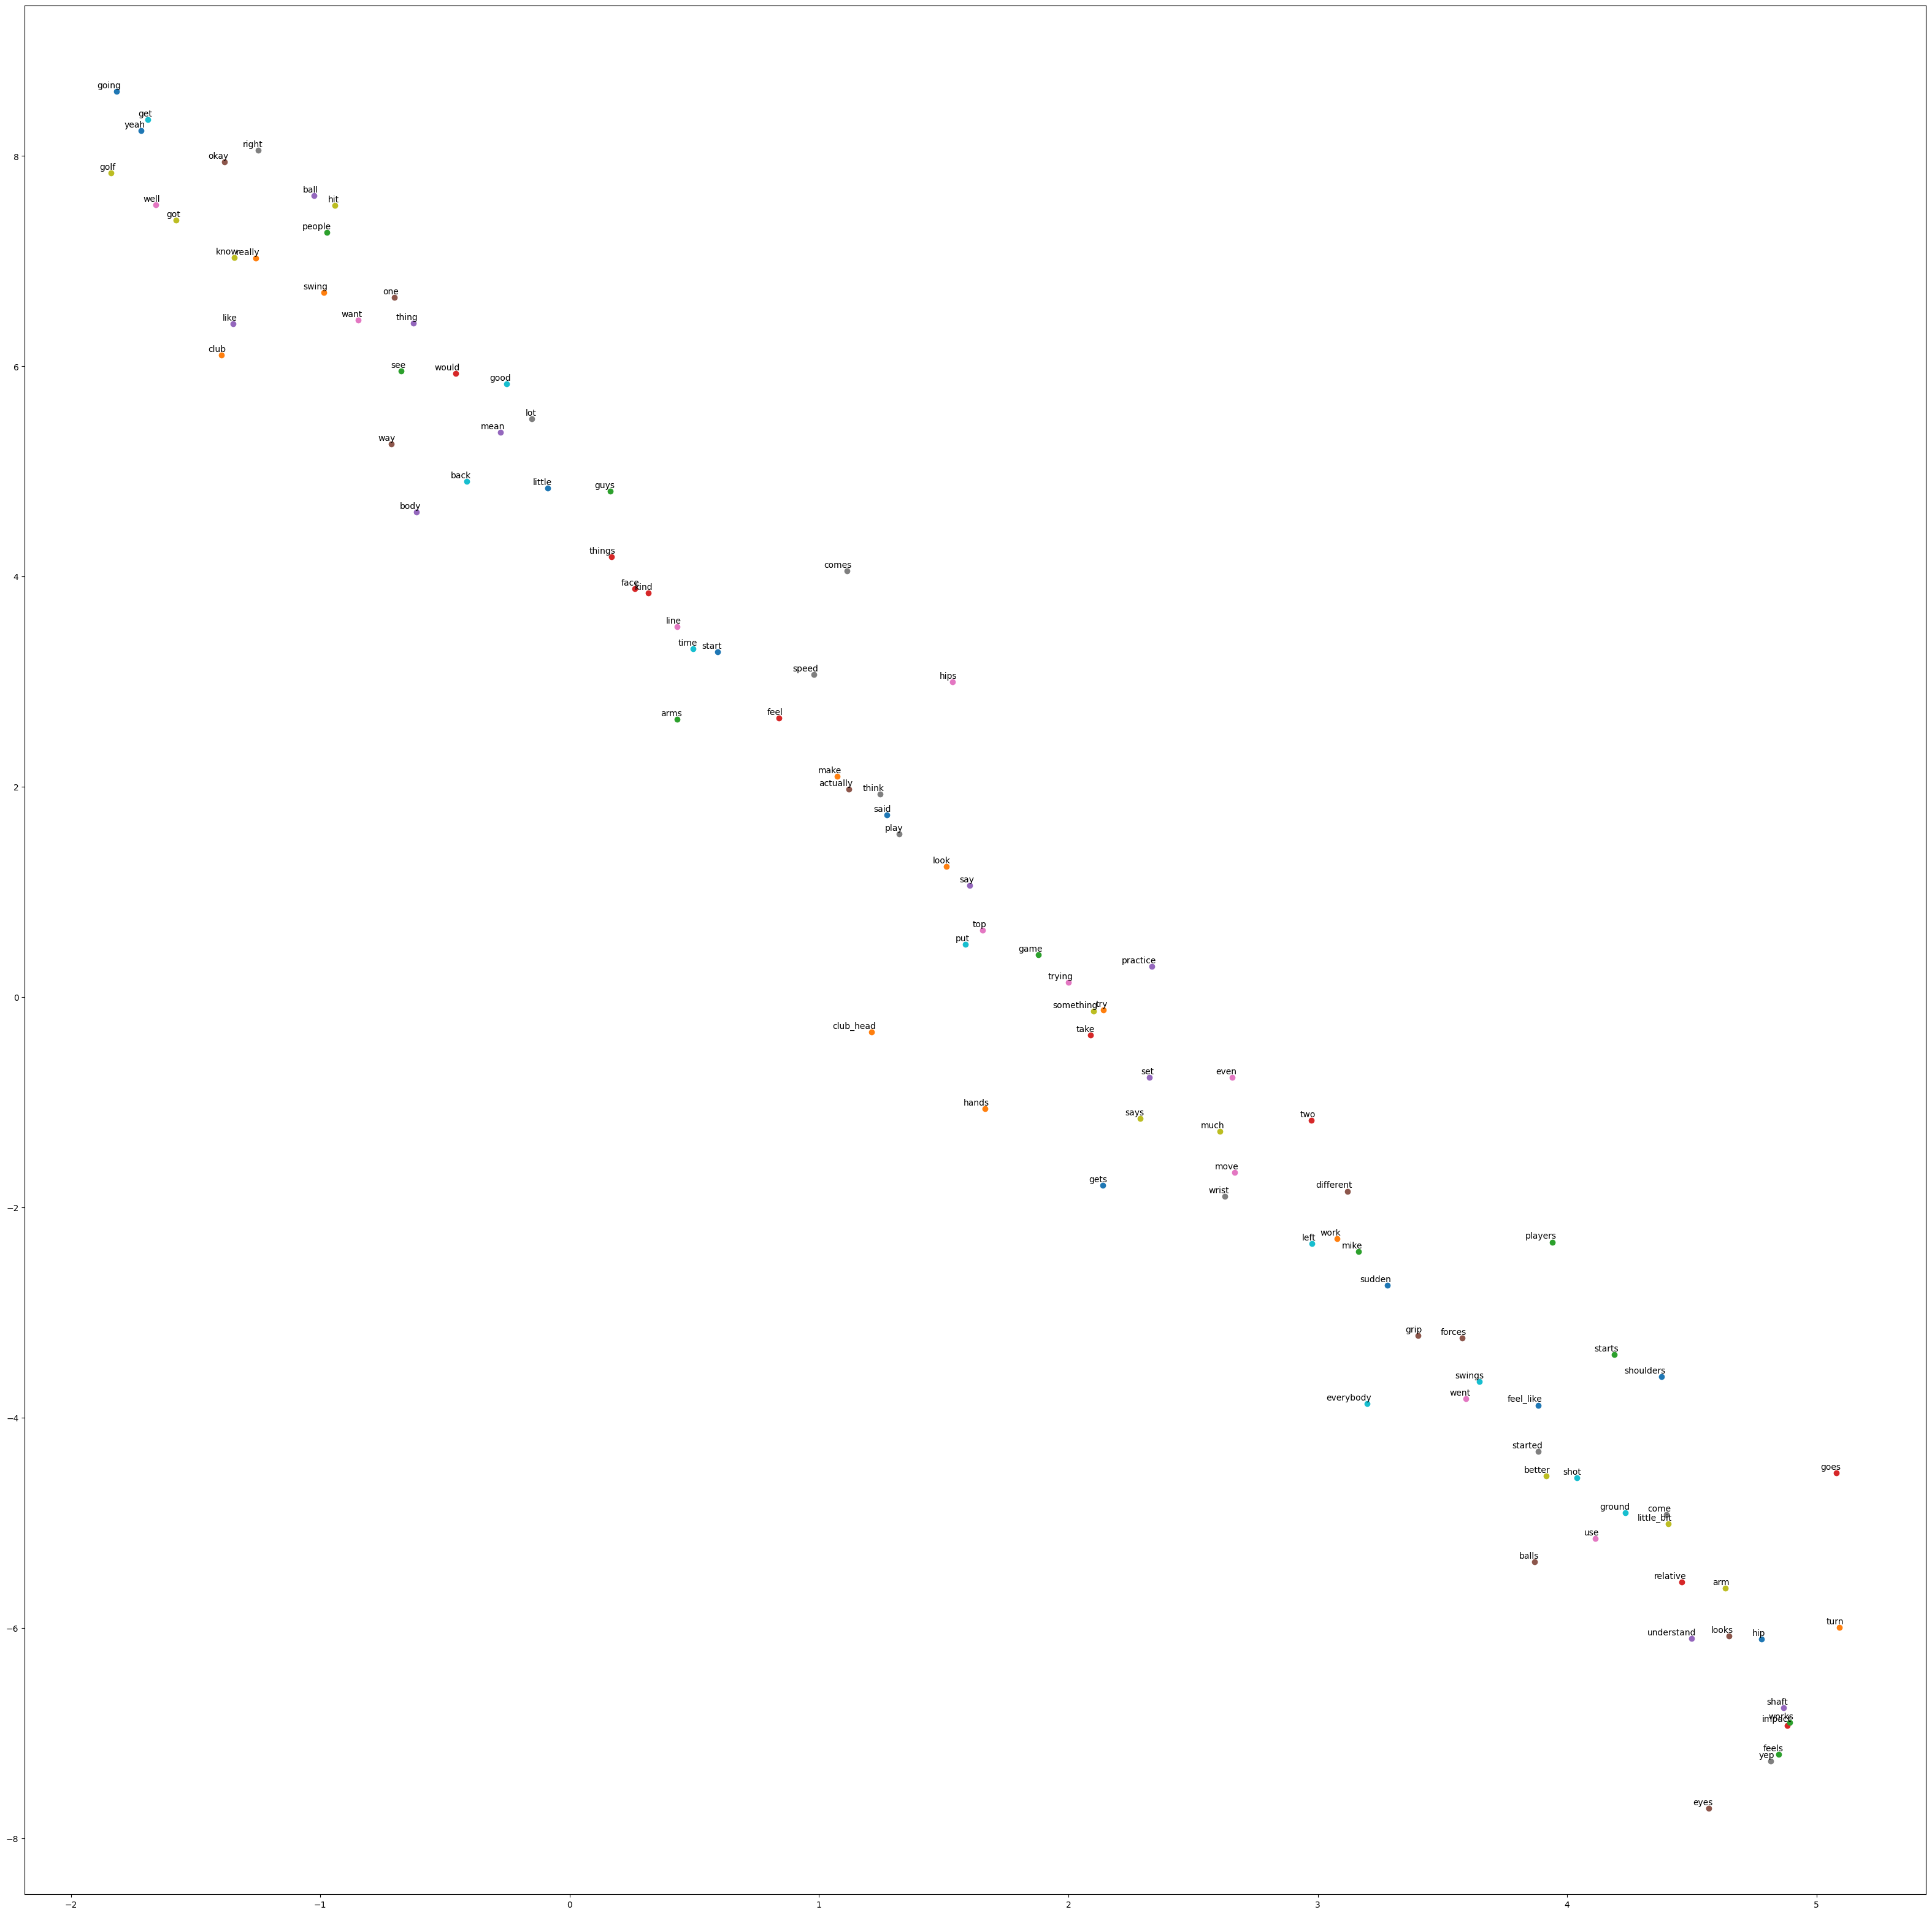

In [ ]:
plot_tsne(filtered_word2vec_df, 30)

### Heat Map of terms

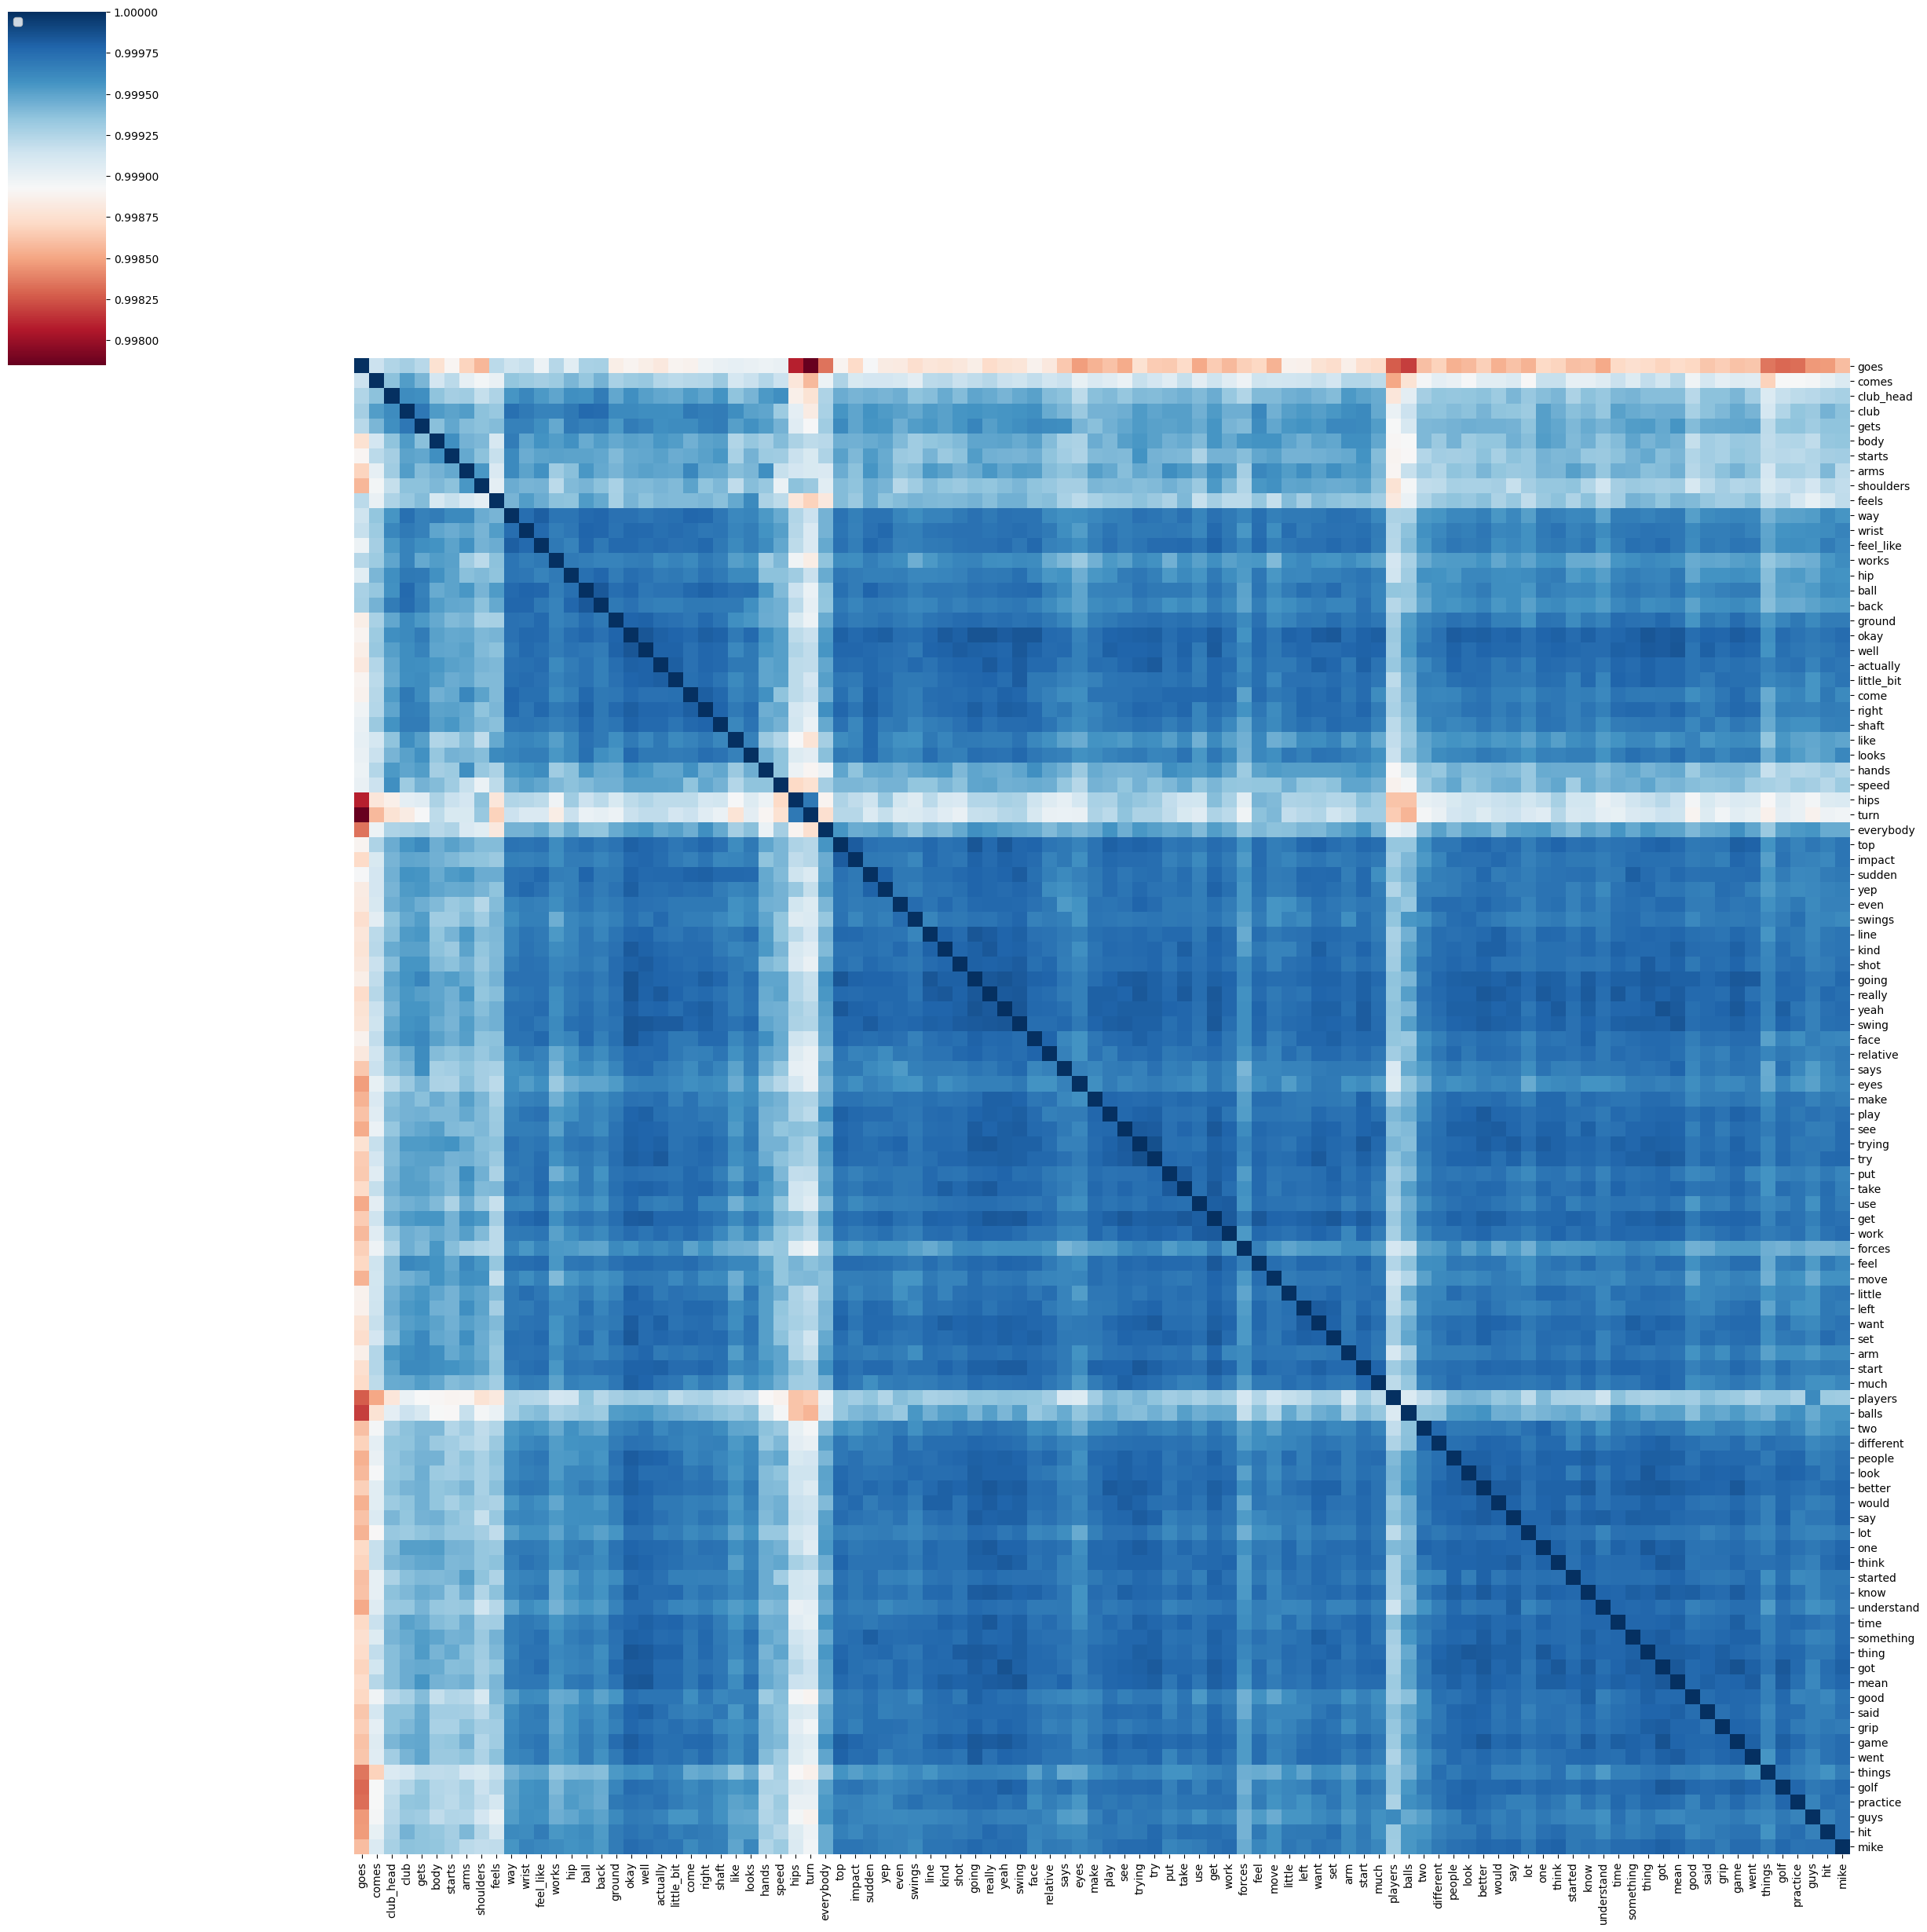

In [ ]:
plot_similarity_matrix(filtered_word2vec_df)
plot_similarity_clustermap(filtered_word2vec_df)

## Create Your Chatbot
https://medium.com/@ritidass29/create-your-chatbot-using-python-nltk-88809fa621d1

### Keyword matching

In [ ]:
# basic response to user inputting a greeting

GREETING_INPUTS = ("hello", "hi", "greetings", "sup", "what's up","hey",)
GREETING_RESPONSES = ["hi", "hey", "*nods*", "hi there", "hello", "I am glad! You are talking to me"]

def greeting(sentence):

    for word in sentence.split():
        if word.lower() in GREETING_INPUTS:
            return random.choice(GREETING_RESPONSES)

In [ ]:
import textwrap

raw = ' '.join(corpus_df['normalized_review'])
sent_tokens = textwrap.wrap(raw, width=100)  # Adjust width as needed
word_tokens = corpus_df['tokenized_review']


#sent_tokens = nltk.sent_tokenize(raw)

In [ ]:
# Fit the vectorizer on sent_tokens
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2), norm=None)
vectorizer.fit(sent_tokens)

TfidfVectorizer(ngram_range=(1, 2), norm=None)

In [ ]:
word_tokens[:5]

0    [comes, golf, careers, mean, lucky, around, lo...
1    [hi, welcome, golfers, md, mike, mille, ask, d...
2    [want, straight, alright, okay, fufufufu, hit,...
3    [alaska, news, tiger, big, news, red, black, u...
4    [first, tournament, feel, good, good, think, l...
Name: tokenized_review, dtype: object

In [ ]:
sent_tokens[:2]

['when it comes to golf careers i mean i ve been very lucky to be around a lot of really good people',
 'in a lot of different industries in the golf industry there was one person that really really had an']

In [ ]:
word_tokens

0      [comes, golf, careers, mean, lucky, around, lo...
1      [hi, welcome, golfers, md, mike, mille, ask, d...
2      [want, straight, alright, okay, fufufufu, hit,...
3      [alaska, news, tiger, big, news, red, black, u...
4      [first, tournament, feel, good, good, think, l...
                             ...                        
199    [question, comes, us, stefan, asking, hitting,...
200    [biggest, difference, golf, course, range, tim...
201    [critical, everybody, moves, ball, okay, stand...
202    [ask, mike, comes, lot, people, asking, integr...
203    [right, come, take, grip, okay, normally, grip...
Name: tokenized_review, Length: 204, dtype: object

In [ ]:
lemmer = nltk.stem.WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmer.lemmatize(token) for token in tokens]
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [ ]:
def response(user_response):
    robo_response=''
    TfidfVec = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english')

    # Add user_response to sent_tokens for vectorization
    temp_sent_tokens = sent_tokens + [user_response]

    tfidf = TfidfVec.fit_transform(temp_sent_tokens)
    vals = cosine_similarity(tfidf[-1], tfidf)

    # Create a mask of False for the last element in vals (i.e., user_response)
    mask = np.ones(vals.shape, dtype=bool)
    mask[0, -1] = False

    # Apply mask to vals and flat vals before argmax
    masked_vals = vals[mask]
    idx = masked_vals.argsort()[-2]
    flat = masked_vals.flatten()
    flat.sort()
    req_tfidf = flat[-2]
    if(req_tfidf==0):
        robo_response=robo_response+"I am sorry! I don't understand you"
        return robo_response
    else:
        robo_response = robo_response+sent_tokens[idx]
        return robo_response

flag=True
print("ROBO: My name is Robo. I will answer your queries about Chatbots. If you want to exit, type Bye!")

while(flag==True):
    user_response = input()
    user_response=user_response.lower()
    if(user_response!='bye'):
        if(user_response=='thanks' or user_response=='thank you' ):
            flag=False
            print("ROBO: You are welcome..")
        else:
            if(greeting(user_response)!=None):
                print("ROBO: "+greeting(user_response))
            else:
                sent_tokens.append(user_response)
                flat_word_tokens = [item for sublist in word_tokens for item in sublist]
                final_words = list(set(flat_word_tokens))
                print("ROBO: ",end="")
                print(response(user_response))
                sent_tokens.remove(user_response)
    else:
        flag=False
        print("ROBO: Bye! take care..")

ROBO: My name is Robo. I will answer your queries about Chatbots. If you want to exit, type Bye!
hi
ROBO: hey
how do I get more distance?
ROBO: about distance because everybody really wanted to know more about distance that seems to be what
how do I hit a draw?
ROBO: that that don t hit draws or don t hit phase there s also a lot of guys who play draw with their
how do I fix my slice?
ROBO: sure yeah so the fixes you fix you fix that yeah you fix that and and then another part of it comes
how do I stop hitting shanks?
ROBO: down you can t stop it from going down you can t stop it from going down but i always see the club
how do I gain confidence?
ROBO: good putter well that i mean first of all confidence in any part of the game is probably the most
how do I control my mental game?
ROBO: to inter mental with that so when you get to the top when you start down as you start down yeah the
thanks
ROBO: You are welcome..
